In [1]:
import numpy as np
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from modules import *

In [2]:
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.family'] = 'Arial'

In [3]:
# random seed
seed = 15
np.random.seed(seed)
random.seed(seed)

In [4]:
# define parameters
n_world = 10000
n_depth = 4
n_branch = 2
sig_b = 1
sig_r = 0.1

# get parameter
prms = get_prms(n_branch = n_branch, n_depth = n_depth, sig_r = sig_r)
n_leaves = prms['n_leaves']

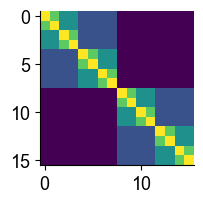

In [5]:
mrca = np.zeros((n_leaves, n_leaves))

for node1 in range(n_leaves):
    for node2 in range(n_leaves):
        transitions1 = np.base_repr(node1, base = prms['n_branch']).zfill(prms['n_depth'])
        transitions2 = np.base_repr(node2, base = prms['n_branch']).zfill(prms['n_depth'])

        for d in range(n_depth):
            if transitions1[d] != transitions2[d]:
                mrca[node1, node2] = d
                break
            mrca[node1, node2] = d + 1

plt.figure(figsize = (2, 2))
plt.imshow(mrca)
plt.show()

In [6]:
all_mean_diffs = []
all_var_diffs = []
all_mrcas = []
all_rollout_indices = []
all_world_indices = []


n_rollouts = 8

for i in range(n_world):
    # draw a world
    mus = assign_mus(prms) # (n_leaves,)

    # prior: m ~ N(0, prior_cov)
    prior_mean = np.zeros((n_leaves,))
    prior_cov = mrca * sig_b ** 2
    # prior_var = np.diag(prior_cov)

    # initialize my and sigma
    Sigma = prior_cov.copy()
    mu = prior_mean.copy()

    # sample all the leaves
    rollout_leaves = np.random.choice(n_leaves, size=n_rollouts, replace=False)

    for k, leaf in enumerate(rollout_leaves):

        # get true and observed cumulative reward from this rollout
        true_cum_reward = mus[leaf]
        g_obs = np.random.normal(loc=true_cum_reward, scale=np.sqrt(n_depth * sig_r**2))

        # update posterior (Bayesian conditioning)
        Sigma_col = Sigma[:, leaf]
        Sigma_ii = Sigma[leaf, leaf]
        gain = Sigma_col / (Sigma_ii + n_depth * sig_r**2)

        # posterior mean update
        mu = mu + gain * (g_obs - mu[leaf])

        # posterior covariance update (rank-one update)
        Sigma = Sigma - np.outer(gain, Sigma_col)

        # record results
        all_mean_diffs.append(np.abs(mu - prior_mean))
        all_var_diffs.append(np.diag(prior_cov) - np.diag(Sigma))
        all_mrcas.append(mrca[leaf])  # leaf of the current rollout
        all_rollout_indices.append(np.ones((n_leaves,)) * k)
        all_world_indices.append(np.ones((n_leaves,)) * i)

        # update prior
        prior_mean = mu.copy()
        prior_cov = Sigma.copy()


all_mean_diffs = np.concatenate(all_mean_diffs)
all_var_diffs = np.concatenate(all_var_diffs)
all_mrcas = np.concatenate(all_mrcas)
all_rollout_indices = np.concatenate(all_rollout_indices)
all_world_indices = np.concatenate(all_world_indices)

In [7]:
df = pd.DataFrame({
    'mean_diffs': all_mean_diffs,
    'var_diffs': all_var_diffs,
    'mrcas': all_mrcas,
    'rollout_indices': all_rollout_indices,
    'world_indices': all_world_indices,
})

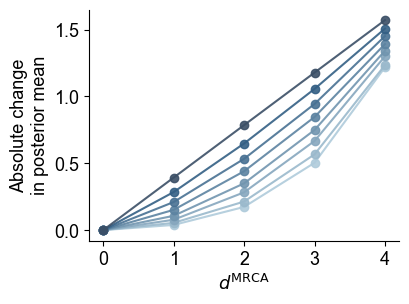

In [8]:
df_grouped = df.groupby(['mrcas', 'rollout_indices', 'world_indices'])['mean_diffs'].mean().reset_index()
df_grouped = df_grouped.groupby(['mrcas', 'rollout_indices'])['mean_diffs'].agg(['mean', 'std']).reset_index()
df_grouped['error'] = df_grouped['std'] / np.sqrt(n_world)

plt.figure(figsize = (4, 3))
colors = ['#3b4f66', '#335f84', '#487193', '#5c83a1', '#7195af', '#86a7be', '#9ab9cc', '#afcbdb']
for i in reversed(range(n_rollouts)):
    df_filtered = df_grouped[df_grouped['rollout_indices'] == i]
    plt.plot(np.arange(n_depth + 1), df_filtered['mean'], color = colors[i], marker = 'o', alpha = 0.9)
    # plt.fill_between(np.arange(n_depth + 1), df_filtered['mean'] - df_filtered['error'], df_filtered['mean'] + df_filtered['error'], alpha = 0.2, linewidth = 0)
plt.xlabel(r'$d^\text{MRCA}$')
plt.ylabel('Absolute change\nin posterior mean')
# plt.show()
plt.savefig('figures/figures_illustration/p_mean.pdf', bbox_inches = 'tight')

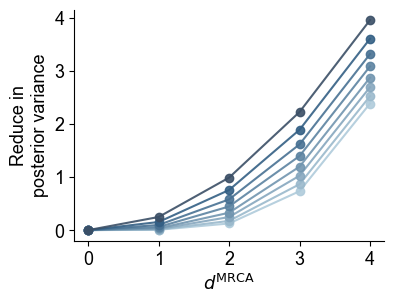

In [9]:
df_grouped = df.groupby(['mrcas', 'rollout_indices', 'world_indices'])['var_diffs'].mean().reset_index()
df_grouped = df_grouped.groupby(['mrcas', 'rollout_indices'])['var_diffs'].agg(['mean', 'std']).reset_index()
df_grouped['error'] = df_grouped['std'] / np.sqrt(n_world)

plt.figure(figsize = (4, 3))
colors = ['#3b4f66', '#335f84', '#487193', '#5c83a1', '#7195af', '#86a7be', '#9ab9cc', '#afcbdb']
for i in reversed(range(n_rollouts)):
    df_filtered = df_grouped[df_grouped['rollout_indices'] == i]
    plt.plot(np.arange(n_depth + 1), df_filtered['mean'], color = colors[i], marker = 'o', alpha = 0.9)
    # plt.fill_between(np.arange(n_depth + 1), df_filtered['mean'] - df_filtered['error'], df_filtered['mean'] + df_filtered['error'], alpha = 0.2, linewidth = 0)
plt.xlabel(r'$d^\text{MRCA}$')
plt.ylabel('Reduce in\nposterior variance')
# plt.show()
plt.savefig('figures/figures_illustration/p_variance.pdf', bbox_inches = 'tight')

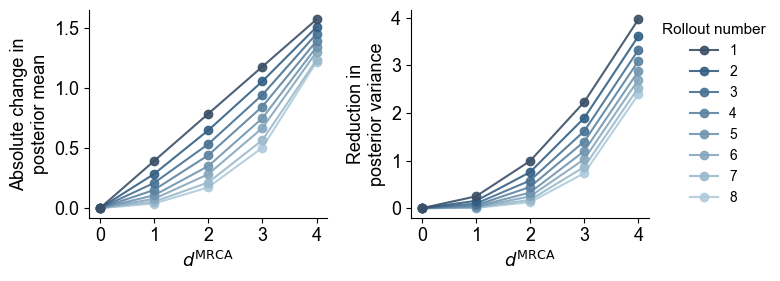

In [10]:
plt.figure(figsize = (8, 3))
colors = ['#3b4f66', '#335f84', '#487193', '#5c83a1', '#7195af', '#86a7be', '#9ab9cc', '#afcbdb']

plt.subplot(1, 2, 1)
df_grouped = df.groupby(['mrcas', 'rollout_indices', 'world_indices'])['mean_diffs'].mean().reset_index()
df_grouped = df_grouped.groupby(['mrcas', 'rollout_indices'])['mean_diffs'].agg(['mean', 'std']).reset_index()
df_grouped['error'] = df_grouped['std'] / np.sqrt(n_world)

for i in reversed(range(n_rollouts)):
    df_filtered = df_grouped[df_grouped['rollout_indices'] == i]
    plt.plot(np.arange(n_depth + 1), df_filtered['mean'], color = colors[i], marker = 'o', alpha = 0.9)
    # plt.fill_between(np.arange(n_depth + 1), df_filtered['mean'] - df_filtered['error'], df_filtered['mean'] + df_filtered['error'], alpha = 0.2, linewidth = 0)
plt.xticks(np.arange(0, n_depth + 1))
plt.xlabel(r'$d^\text{MRCA}$')
plt.ylabel('Absolute change in\nposterior mean')

plt.subplot(1, 2, 2)
df_grouped = df.groupby(['mrcas', 'rollout_indices', 'world_indices'])['var_diffs'].mean().reset_index()
df_grouped = df_grouped.groupby(['mrcas', 'rollout_indices'])['var_diffs'].agg(['mean', 'std']).reset_index()
df_grouped['error'] = df_grouped['std'] / np.sqrt(n_world)

for i in reversed(range(n_rollouts)):
    df_filtered = df_grouped[df_grouped['rollout_indices'] == i]
    plt.plot(np.arange(n_depth + 1), df_filtered['mean'], color = colors[i], label = i + 1, marker = 'o', alpha = 0.9)
    # plt.fill_between(np.arange(n_depth + 1), df_filtered['mean'] - df_filtered['error'], df_filtered['mean'] + df_filtered['error'], alpha = 0.2, linewidth = 0)
plt.xticks(np.arange(0, n_depth + 1))
plt.xlabel(r'$d^\text{MRCA}$')
plt.ylabel('Reduction in\nposterior variance')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor = (1, 0.5), loc = 'center left', fontsize = 10, frameon = False, title = 'Rollout number', title_fontsize = '11')
plt.tight_layout()
plt.savefig('figures/figures_illustration/p_both.pdf', bbox_inches = 'tight')